## Diagonal integration using spaAnchor

In this section, we illustrate spaAnchor for diagonal integration.

We use the Xenium obtained [human breast cancer](https://www.10xgenomics.com/products/xenium-in-situ/preview-dataset-human-breast) for evaluation.
In this experiment, we simulated a scenario with zero molecular overlap between two tissue slices. To achieve this, we partitioned the available gene panel into two distinct, non-overlapping sets: 156 unique genes were assigned to the first slice, and 157 unique genes were assigned to the second. Consequently, the paired H&E histology image served as the anchor to diagonal integration.
The model is then tasked with predicting the unmeasured panels for every slice.

In [1]:
import scanpy as sc
import spaAnchor as sa
from scipy.stats import pearsonr

adata0 = sc.read_h5ad("/mnt/sde/data/xenium_hbc/xenium_hbc_rep1_img.h5ad")
adata1 = sc.read_h5ad("/mnt/sde/data/xenium_hbc/xenium_hbc_rep2_img.h5ad")
adata1 = adata1[adata1.obs["in_img"]]
gene_dict = sa.utils.assign_genes(adata0.var_names, 0, [156, 157])

The histology image should be stored at `adata0.uns["spatial"][library_id]["images"][img_basis]`.
User can use our pre-built `sa.diagonal_integration` class for diagonal integration.
To perform diagonal integration, user should firstly download the pre-trained HIPT model parameters as detailed in our [installation instructions](https://spaanchor.readthedocs.io/en/latest/install.html). Subsequently, assign the file path of these downloaded parameters to the `model_path` parameter.

In [2]:
model = sa.diagonal_integration("vit256_small_dino.pth", library_id="histology_img")
predicted_result = model([
    adata0[:, gene_dict['slice_0']].copy(), 
    adata1[:, gene_dict['slice_1']].copy()
])

Take key teacher in provided checkpoint dict
Pretrained weights found at /mnt/sde/info_trans/info_trans_script/packages/spaAnchor/modules/../utils/HIPT/vit256_small_dino.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])


100%|██████████| 22/22 [02:06<00:00,  5.75s/it]


INFO: Finish HANN pairs finding. (23.683s)


INFO: Learn aggregate attention score: 100%|██████████| 500/500 [00:01<00:00, 269.00it/s]


INFO: Finish transformation. (26.696s)


User can further assess the model's performance by comparing the predicted expression of a key gene, like *EPCAM*, against its measured value. 

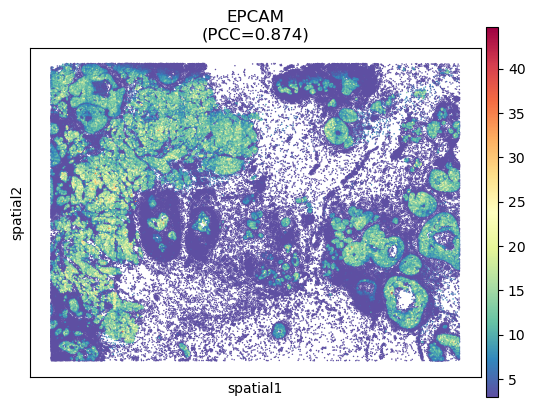

In [3]:
adata0.obs_names += f"-0"
result_adata0 = adata0[predicted_result[0]["X"].index]
result_adata0.obs["pred_EPCAM"] = predicted_result[0]["X"]["EPCAM"]
pcc = pearsonr(result_adata0[:, "EPCAM"].X.toarray().T[0], result_adata0.obs["pred_EPCAM"])[0]
sc.pl.spatial(result_adata0, color=["pred_EPCAM"], cmap="Spectral_r", 
              title=f"EPCAM\n(PCC={pcc:.3f})",
              vmin=3, library_id=None, spot_size=45)